In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'augmented-forest-segmentation' dataset.
Path to dataset files: /kaggle/input/augmented-forest-segmentation


In [5]:
!pip -q install -U segmentation-models-pytorch albumentations torchmetrics opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.2 MB/s eta 0:00:00


In [6]:
import os
print(os.listdir(path))

['Forest Segmented', 'meta_data.csv']


In [7]:
import os, glob, pandas as pd

# 0) ОПОРНЫЙ ПУТЬ (ты уже получал его через kagglehub.dataset_download)
print("Base dataset path:", path)

# 1) Ищем meta_data.csv внутри датасета
meta_candidates = glob.glob(os.path.join(path, "**", "meta_data.csv"), recursive=True)
assert meta_candidates, "meta_data.csv не найден — покажи структуру папок, подстроим поиск."
meta_path = meta_candidates[0]
print("meta_data.csv:", meta_path)

# 2) Парсим CSV
df = pd.read_csv(meta_path)
print("CSV columns:", list(df.columns))
display(df.head())

# 3) Ищем папки images/ и masks/ (некоторые версии датасета имеют вложенную папку 'Forest Segmented/Forest Segmented')
img_dirs  = [d for d in glob.glob(os.path.join(path, "**", "images"), recursive=True)]
mask_dirs = [d for d in glob.glob(os.path.join(path, "**", "masks"),  recursive=True)]
assert img_dirs and mask_dirs, "Не нашёл папки images/ и/или masks/. Покажи вывод os.walk — поправим."

images_dir, masks_dir = img_dirs[0], mask_dirs[0]
print("images_dir:", images_dir)
print("masks_dir :", masks_dir)

# 4) Проверим существование файлов из CSV в найденных папках
missing_images = []
missing_masks  = []

for _, row in df.iterrows():
    img_ok  = os.path.exists(os.path.join(images_dir, row["image"]))
    mask_ok = os.path.exists(os.path.join(masks_dir,  row["mask"]))
    if not img_ok:  missing_images.append(row["image"])
    if not mask_ok: missing_masks.append(row["mask"])

print(f"Всего строк в CSV: {len(df)}")
print(f"Не найдено изображений: {len(missing_images)}")
print(f"Не найдено масок     : {len(missing_masks)}")

# Покажем по одному «живому» пути для контроля
if len(df) > 0:
    sample_img_path  = os.path.join(images_dir, df.loc[0, "image"])
    sample_mask_path = os.path.join(masks_dir,  df.loc[0, "mask"])
    print("Пример image:", sample_img_path)
    print("Пример mask :", sample_mask_path)


Base dataset path: /kaggle/input/augmented-forest-segmentation
meta_data.csv: /kaggle/input/augmented-forest-segmentation/meta_data.csv
CSV columns: ['image', 'mask']


,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


images_dir: /kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images
masks_dir : /kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks
Всего строк в CSV: 5108
Не найдено изображений: 0
Не найдено масок     : 0
Пример image: /kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg
Пример mask : /kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/10452_mask_08.jpg


— index: 468
  image: 15573_sat_66.jpg | shape: (256, 256, 3) | dtype: uint8
  mask : 15573_mask_66.jpg | shape: (256, 256, 3) | dtype: uint8
  mask has 3 channels; identical channels: True
  unique mask values: [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255] (n = 16 ), min/max: 0 255


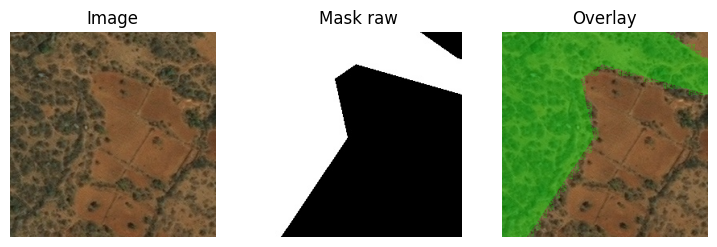

— index: 2241
  image: 498049_sat_50.jpg | shape: (256, 256, 3) | dtype: uint8
  mask : 498049_mask_50.jpg | shape: (256, 256, 3) | dtype: uint8
  mask has 3 channels; identical channels: True
  unique mask values: [  0   1   2   3   4   5 249 250 251 252 253 254 255] (n = 13 ), min/max: 0 255


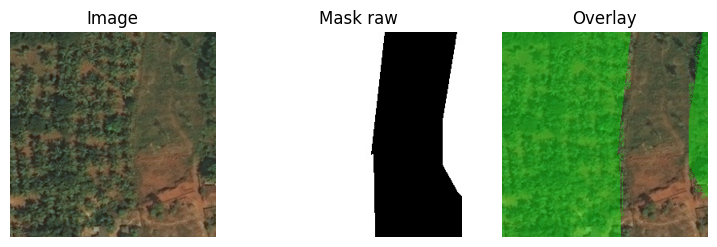

— index: 602
  image: 174980_sat_00.jpg | shape: (256, 256, 3) | dtype: uint8
  mask : 174980_mask_00.jpg | shape: (256, 256, 3) | dtype: uint8
  mask has 3 channels; identical channels: True
  unique mask values: [  0   1   2   3   5   7 250 251 252 253 254 255] (n = 12 ), min/max: 0 255


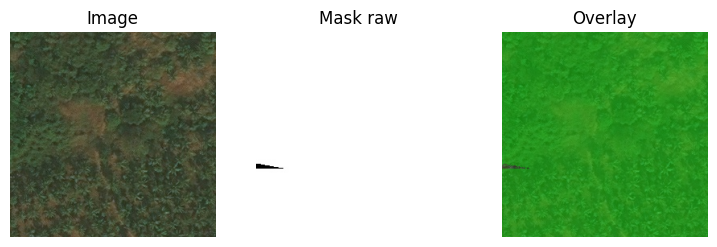

In [8]:
import os, random, numpy as np, cv2, matplotlib.pyplot as plt

# считаем, что переменные уже есть из предыдущего шага:
# path, images_dir, masks_dir, df

def inspect_pair(i):
    img_path  = os.path.join(images_dir, df.loc[i, "image"])
    mask_path = os.path.join(masks_dir,  df.loc[i, "mask"])

    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    mask_raw = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    print("— index:", i)
    print("  image:", os.path.basename(img_path), "| shape:", img.shape, "| dtype:", img.dtype)
    print("  mask :", os.path.basename(mask_path), "| shape:", mask_raw.shape, "| dtype:", mask_raw.dtype)

    m = mask_raw
    if m.ndim == 3:
        same_channels = np.all(m[...,0] == m[...,1]) and np.all(m[...,1] == m[...,2])
        print("  mask has 3 channels; identical channels:", bool(same_channels))
        m = m[...,0]  # возьмем 1-й канал для анализа/визуализации

    vals = np.unique(m)
    print("  unique mask values:", vals[:20], "(n =", len(vals), "), min/max:", int(m.min()), int(m.max()))

    # Небольшое превью наложения (бинаризуем >0)
    m_bin = (m > 0).astype(np.uint8)

    fig = plt.figure(figsize=(9, 3))
    ax1 = fig.add_subplot(1,3,1); ax1.imshow(img); ax1.set_title("Image"); ax1.axis("off")
    ax2 = fig.add_subplot(1,3,2); ax2.imshow(m, cmap="gray"); ax2.set_title("Mask raw"); ax2.axis("off")

    overlay = img.copy()
    overlay[m_bin.astype(bool)] = (0.6*overlay[m_bin.astype(bool)] + 0.4*np.array([0,255,0])).astype(np.uint8)
    ax3 = fig.add_subplot(1,3,3); ax3.imshow(overlay); ax3.set_title("Overlay"); ax3.axis("off")
    plt.show()

# проверим на 3 случайных примерах
idxs = random.sample(range(len(df)), 3)
for i in idxs:
    inspect_pair(i)


In [9]:
import os, cv2, numpy as np
from torch.utils.data import Dataset

class ForestSegDataset(Dataset):
    def __init__(self, df, images_dir, masks_dir, transforms):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.t = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        img_path  = os.path.join(self.images_dir, self.df.loc[i, "image"])
        mask_path = os.path.join(self.masks_dir,  self.df.loc[i, "mask"])

        img  = cv2.cvtColor(cv2.imread(img_path,  cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # если маска 3-канальная (бывает), берём первый канал
        if mask.ndim == 3:
            mask = mask[..., 0]

        # бинаризация (0/255 → 0/1)
        mask = (mask > 0).astype(np.float32)

        aug = self.t(image=img, mask=mask)
        x   = aug["image"]                 # [3,H,W]
        y   = aug["mask"].unsqueeze(0)     # [1,H,W]
        return x, y


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_H, IMG_W = 256, 256

train_transform = A.Compose([
    A.Resize(height=IMG_H, width=IMG_W),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Affine(scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),  # без shear/translate параметров
    A.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.05, p=0.3),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMG_H, width=IMG_W),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])


In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

TEST_SIZE   = 0.2
BATCH_SIZE  = 8
RANDOM_SEED = 42

# 1) делим датафрейм на train / test
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)

# 2) собираем датасеты (train с аугментациями, test — без рандома)
train_ds = ForestSegDataset(train_df, images_dir, masks_dir, train_transform)
test_ds  = ForestSegDataset(test_df,  images_dir, masks_dir, val_transform)

# 3) DataLoader'ы
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)



(4086, 1022)

In [12]:
xb, yb = next(iter(train_loader))
print("X train:", xb.shape, xb.dtype)
print("Y train:", yb.shape, yb.dtype, yb.min().item(), yb.max().item())

xb_t, yb_t = next(iter(test_loader))
print("X test :", xb_t.shape, xb_t.dtype)
print("Y test :", yb_t.shape, yb_t.dtype, yb_t.min().item(), yb_t.max().item())


X train: torch.Size([8, 3, 256, 256]) torch.float32
Y train: torch.Size([8, 1, 256, 256]) torch.float32 0.0 1.0
X test : torch.Size([8, 3, 256, 256]) torch.float32
Y test : torch.Size([8, 1, 256, 256]) torch.float32 0.0 1.0


In [13]:
import torch
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",      # базовый и быстрый
    encoder_weights="imagenet",   # предобученные веса
    in_channels=3,
    classes=1                     # бинарная сегментация
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [14]:
import torch.nn as nn
import torch.nn.functional as F

bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    # logits: [B,1,H,W]; targets: [B,1,H,W] в {0,1}
    probs = torch.sigmoid(logits)
    num = 2.0 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    return 1.0 - (num / den).mean()

def combo_loss(logits, targets, alpha=0.5):
    return alpha * bce(logits, targets) + (1 - alpha) * dice_loss(logits, targets)


In [15]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
torch.backends.cudnn.benchmark = True



CUDA available: True
Device: Tesla T4


In [16]:
# (переопредели модель, если хочешь быстрее)
import segmentation_models_pytorch as smp
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

import torch.nn as nn
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2*(p*targets).sum(dim=(2,3))
    den = (p+targets).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

def combo_loss(logits, targets, a=0.5):
    return a*bce(logits, targets) + (1-a)*dice_loss(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/tmp/ipython-input-3904328664.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [17]:
# (переопредели модель, если хочешь быстрее)
import segmentation_models_pytorch as smp
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

import torch.nn as nn
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2*(p*targets).sum(dim=(2,3))
    den = (p+targets).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

def combo_loss(logits, targets, a=0.5):
    return a*bce(logits, targets) + (1-a)*dice_loss(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


/tmp/ipython-input-3904328664.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [18]:
# (переопредели модель, если хочешь быстрее)
import segmentation_models_pytorch as smp
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

import torch.nn as nn
bce = nn.BCEWithLogitsLoss()

def dice_loss(logits, targets, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2*(p*targets).sum(dim=(2,3))
    den = (p+targets).sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

def combo_loss(logits, targets, a=0.5):
    return a*bce(logits, targets) + (1-a)*dice_loss(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


/tmp/ipython-input-3904328664.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [20]:
def binarize(logits, thr=0.5):
    return (torch.sigmoid(logits) > thr).float()

def iou_score(pred, target, eps=1e-7):
    inter = (pred*target).sum(dim=(2,3))
    union = (pred + target - pred*target).sum(dim=(2,3)) + eps
    return (inter/union).mean()

def f1_score(pred, target, eps=1e-7):
    tp = (pred*target).sum(dim=(2,3))
    fp = (pred*(1-target)).sum(dim=(2,3))
    fn = ((1-pred)*target).sum(dim=(2,3))
    return (2*tp/(2*tp+fp+fn+eps)).mean()

def train_one_epoch_fast(model, loader, optimizer, device, max_batches=100):
    model.train()
    loss_sum=iou_sum=f1_sum=n=0
    for b, (x,y) in enumerate(loader):
        if b>=max_batches: break
        x,y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(x)
            loss = combo_loss(logits, y)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        with torch.no_grad():
            pred = binarize(logits)
            bs = x.size(0)
            loss_sum += loss.item()*bs
            iou_sum  += iou_score(pred,y).item()*bs
            f1_sum   += f1_score(pred,y).item()*bs
            n += bs
    return loss_sum/n, iou_sum/n, f1_sum/n

@torch.no_grad()
def evaluate_fast(model, loader, device, max_batches=50):
    model.eval()
    loss_sum=iou_sum=f1_sum=n=0
    for b, (x,y) in enumerate(loader):
        if b>=max_batches: break
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = combo_loss(logits, y)
        pred = binarize(logits)
        bs = x.size(0)
        loss_sum += loss.item()*bs
        iou_sum  += iou_score(pred,y).item()*bs
        f1_sum   += f1_score(pred,y).item()*bs
        n += bs
    return loss_sum/n, iou_sum/n, f1_sum/n


In [24]:
for epoch in range(1, 20):
    tr_loss, tr_iou, tr_f1 = train_one_epoch_fast(model, train_loader, optimizer, device, max_batches=100)
    te_loss, te_iou, te_f1 = evaluate_fast(model, test_loader,  device, max_batches=50)
    print(f"Epoch {epoch:02d} | "
          f"train: loss={tr_loss:.4f} IoU={tr_iou:.4f} F1={tr_f1:.4f}  ||  "
          f"test: loss={te_loss:.4f} IoU={te_iou:.4f} F1={te_f1:.4f}")


/tmp/ipython-input-1172794272.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train: loss=0.3677 IoU=0.6802 F1=0.7586  ||  test: loss=0.3900 IoU=0.6523 F1=0.7378
Epoch 02 | train: loss=0.3615 IoU=0.6860 F1=0.7642  ||  test: loss=0.3656 IoU=0.6844 F1=0.7641
Epoch 03 | train: loss=0.3691 IoU=0.6736 F1=0.7527  ||  test: loss=0.4020 IoU=0.6646 F1=0.7505
Epoch 04 | train: loss=0.3698 IoU=0.6793 F1=0.7559  ||  test: loss=0.3797 IoU=0.6789 F1=0.7607
Epoch 05 | train: loss=0.3567 IoU=0.6840 F1=0.7643  ||  test: loss=0.3796 IoU=0.6807 F1=0.7581
Epoch 06 | train: loss=0.3637 IoU=0.6841 F1=0.7616  ||  test: loss=0.3519 IoU=0.6935 F1=0.7702
Epoch 07 | train: loss=0.3493 IoU=0.6923 F1=0.7718  ||  test: loss=0.3576 IoU=0.6870 F1=0.7646
Epoch 08 | train: loss=0.3499 IoU=0.6848 F1=0.7655  ||  test: loss=0.3684 IoU=0.6833 F1=0.7608
Epoch 09 | train: loss=0.3644 IoU=0.6779 F1=0.7556  ||  test: loss=0.4141 IoU=0.6371 F1=0.7232
Epoch 10 | train: loss=0.3714 IoU=0.6698 F1=0.7523  ||  test: loss=0.3782 IoU=0.6627 F1=0.7467
Epoch 11 | train: loss=0.3506 IoU=0.6890 F1=0.7688

In [28]:
# ↓↓↓ только этот блок вставь вместо предыдущего цикла дообучения ↓↓↓
# Снижаем LR в 10 раз для fine-tune
for g in optimizer.param_groups:
    g['lr'] = max(g['lr'] * 0.1, 1e-5)
print("New LR:", optimizer.param_groups[0]['lr'])

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

best_iou = -1.0
wait = 0
patience = 3
best_path = "unet_resnet18_best.pt"
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    # полный проход БЕЗ изменений функций: передаем число батчей
    tr_loss, tr_iou, tr_f1 = train_one_epoch_fast(
        model, train_loader, optimizer, device, max_batches=len(train_loader)
    )
    te_loss, te_iou, te_f1 = evaluate_fast(
        model, test_loader, device, max_batches=len(test_loader)
    )

    print(f"Epoch {epoch:02d} | "
          f"train: loss={tr_loss:.4f} IoU={tr_iou:.4f} F1={tr_f1:.4f}  ||  "
          f"test: loss={te_loss:.4f} IoU={te_iou:.4f} F1={te_f1:.4f}")

    # шаг планировщика по test loss
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(te_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"LR reduced: {old_lr:.2e} -> {new_lr:.2e}")

    # early stopping по улучшению test IoU
    if te_iou > best_iou + 1e-4:
        best_iou = te_iou
        wait = 0
        torch.save(model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop (no IoU improvement {patience} epochs). Best IoU={best_iou:.4f}")
            break

print(f"Best test IoU: {best_iou:.4f}  | Weights: {best_path}")


New LR: 1e-05


/tmp/ipython-input-1172794272.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train: loss=0.3258 IoU=0.7043 F1=0.7792  ||  test: loss=0.3203 IoU=0.7035 F1=0.7775
Epoch 02 | train: loss=0.3219 IoU=0.7090 F1=0.7829  ||  test: loss=0.3185 IoU=0.7088 F1=0.7827
Epoch 03 | train: loss=0.3199 IoU=0.7082 F1=0.7813  ||  test: loss=0.3177 IoU=0.7086 F1=0.7824
Epoch 04 | train: loss=0.3170 IoU=0.7096 F1=0.7830  ||  test: loss=0.3183 IoU=0.7079 F1=0.7817
Epoch 05 | train: loss=0.3169 IoU=0.7114 F1=0.7847  ||  test: loss=0.3183 IoU=0.7004 F1=0.7747
LR reduced: 1.00e-05 -> 5.00e-06
Early stop (no IoU improvement 3 epochs). Best IoU=0.7088
Best test IoU: 0.7088  | Weights: unet_resnet18_best.pt


In [29]:
import torch, numpy as np

model.eval()
device = next(model.parameters()).device

@torch.no_grad()
def sweep_thresholds(model, loader, thresholds=np.linspace(0.1, 0.9, 17)):
    def binarize(p, thr): return (p > thr).float()
    def iou(pred, tgt, eps=1e-7):
        inter = (pred*tgt).sum(dim=(2,3))
        union = (pred + tgt - pred*tgt).sum(dim=(2,3)) + eps
        return (inter/union).mean()
    def f1(pred, tgt, eps=1e-7):
        tp = (pred*tgt).sum(dim=(2,3))
        fp = (pred*(1-tgt)).sum(dim=(2,3))
        fn = ((1-pred)*tgt).sum(dim=(2,3))
        return (2*tp/(2*tp+fp+fn+eps)).mean()

    results = []
    # Полный проход (можно укоротить: max_batches = min(len(loader), 60))
    for thr in thresholds:
        iou_sum=f1_sum=n=0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            probs = torch.sigmoid(model(xb))          # [B,1,H,W]
            pred  = binarize(probs, thr)
            bs = xb.size(0)
            iou_sum += iou(pred, yb).item()*bs
            f1_sum  += f1(pred, yb).item()*bs
            n += bs
        results.append((float(thr), iou_sum/n, f1_sum/n))
    # найдём лучший по IoU
    best = max(results, key=lambda x: x[1])
    print("Threshold sweep (thr, IoU, F1) — первые 5:", results[:5])
    print(f"BEST: thr={best[0]:.2f}  IoU={best[1]:.4f}  F1={best[2]:.4f}")
    return results, best

results, best = sweep_thresholds(model, test_loader)
best_thr = best[0]
best_thr


Threshold sweep (thr, IoU, F1) — первые 5: [(0.1, 0.6896429750084178, 0.7690296742314229), (0.15000000000000002, 0.7002882019647647, 0.7778546924460424), (0.2, 0.7056204554152815, 0.7819252788670609), (0.25, 0.7086579246763614, 0.7838254895228929), (0.30000000000000004, 0.709627923083632, 0.7842505498408338)]
BEST: thr=0.30  IoU=0.7096  F1=0.7843


0.30000000000000004

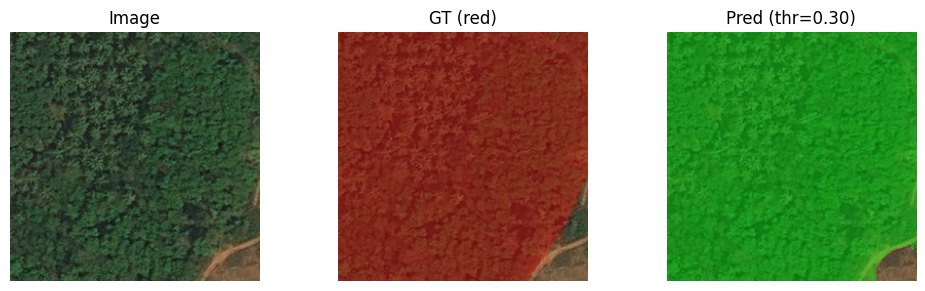

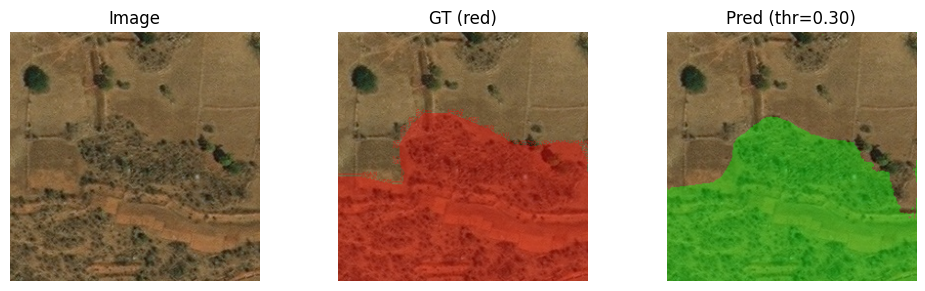

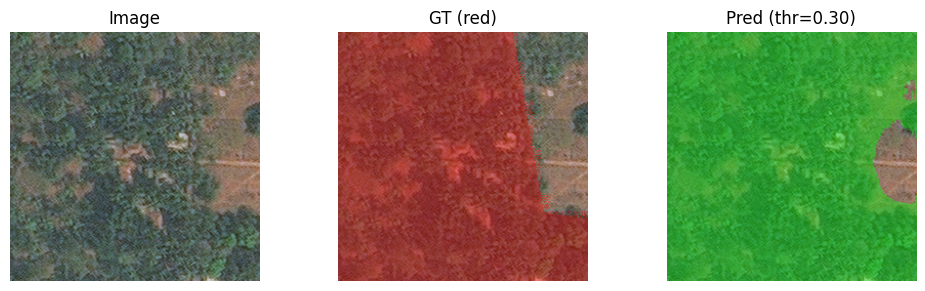

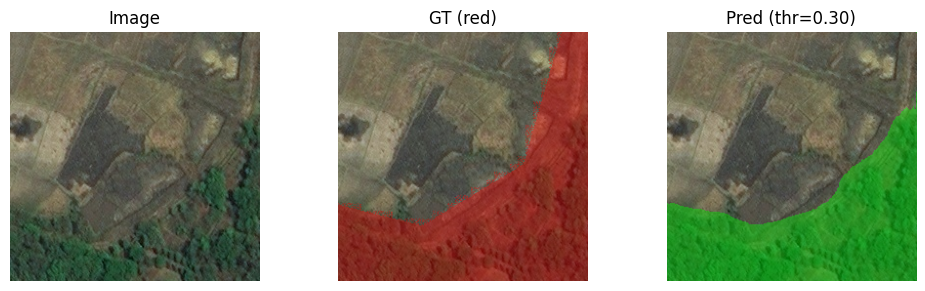

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
device = next(model.parameters()).device

def show_preds_with_thr(loader, thr, n_imgs=4):
    shown = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            probs = torch.sigmoid(model(xb)).cpu().numpy()  # [B,1,H,W]
            preds = (probs > thr).astype(np.uint8)

            imgs = xb.cpu().numpy()   # [B,3,H,W], нормированные
            gts  = yb.cpu().numpy()   # [B,1,H,W]

            B = imgs.shape[0]
            for i in range(min(B, n_imgs - shown)):
                img = imgs[i].transpose(1,2,0)
                img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
                img = np.clip(img, 0, 1)

                gt   = gts[i,0]
                pred = preds[i,0]

                ov_pred = (img*255).astype(np.uint8).copy()
                ov_pred[pred.astype(bool)] = (0.6*ov_pred[pred.astype(bool)] + 0.4*np.array([0,255,0])).astype(np.uint8)

                ov_gt = (img*255).astype(np.uint8).copy()
                ov_gt[gt.astype(bool)] = (0.6*ov_gt[gt.astype(bool)] + 0.4*np.array([255,0,0])).astype(np.uint8)

                plt.figure(figsize=(10,3))
                plt.subplot(1,3,1); plt.imshow(img);    plt.title("Image");     plt.axis("off")
                plt.subplot(1,3,2); plt.imshow(ov_gt);  plt.title("GT (red)");  plt.axis("off")
                plt.subplot(1,3,3); plt.imshow(ov_pred);plt.title(f"Pred (thr={thr:.2f})"); plt.axis("off")
                plt.tight_layout(); plt.show()

                shown += 1
                if shown >= n_imgs:
                    return

show_preds_with_thr(test_loader, best_thr, n_imgs=4)


In [32]:
import json, os, torch

weights_path = "unet_resnet18_best.pt"   # если у тебя уже сохранён лучший — ок
cfg_path     = "unet_config.json"

# если лучший ещё не сохранили — сохраним текущее состояние
if not os.path.exists(weights_path):
    torch.save(model.state_dict(), weights_path)

cfg = {
    "encoder_name": "resnet18",
    "img_size": [256, 256],
    "threshold": float(best_thr),
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std":  [0.229, 0.224, 0.225]
}
with open(cfg_path, "w") as f:
    json.dump(cfg, f, indent=2)
print("Saved:", os.path.abspath(weights_path))
print("Saved:", os.path.abspath(cfg_path))


Saved: /content/unet_resnet18_best.pt
Saved: /content/unet_config.json
